## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import matplotlib
%matplotlib inline

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trial as n_counts_simulator

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.020, 0.6, 0.55, 0.94, -2.50])
upper = np.array([0.1275, 0.024, 1.1, 0.90, 1.00, -0.33])
prior = priors.Uniform(lower, upper)

## Define some fiducial parameters

In [6]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76, 0.69, 0.9655, -1])

In [7]:
N_countsSimulator = n_counts_simulator.Model()

In [8]:
N_countsSimulator.N_counts

array([17848.4613, 57696.9893, 79195.8165, 76027.8893, 58851.194 ])

In [9]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

In [10]:
def compressor(data, compressor_args):
    return data
compressor_args=None

In [13]:
N_counts_data = N_countsSimulator.data
N_counts_data.shape

(5,)

In [12]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=6, n_data=5, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=5, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=5, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=5, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=6, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

In [14]:
DelfiEnsemble = delfi.Delfi(N_counts_data, prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}', 'h', 'n_{s}', 'w_{0}'],
                            results_dir = "simulators/mass_function_n_counts/results_trial/")

In [15]:
n_initial = 5 #200
n_batch = 5 #200
n_populations = 10 #20

In [16]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, batch_size=5, 
                                  save_intermediate_posteriors=True)

0 0
1 0
Simulator returns exception for parameter values: [ 0.1161436   0.0237735   0.94919543  0.70475089  0.98101741 -1.79192855] (rank 0)
Simulator returns exception for parameter values: [ 0.12385868  0.02053709  0.97533491  0.88770196  0.98072611 -1.40238987] (rank 0)
Simulator returns exception for parameter values: [ 0.11390802  0.02166032  0.73452915  0.63685479  0.98132586 -1.43559016] (rank 0)
0 0
1 0
2 0
3 0
Simulator returns exception for parameter values: [ 0.11395326  0.02251315  0.83943282  0.82728762  0.98912905 -0.59037998] (rank 0)
0 0
1 0
2 0
3 0
Simulator returns exception for parameter values: [ 0.12645814  0.02184975  0.90779404  0.64101238  0.98633061 -1.7178181 ] (rank 0)
0 0
1 0
2 0
3 0
Simulator returns exception for parameter values: [ 0.12401079  0.02015931  1.06288024  0.59725966  0.97928627 -1.04918805] (rank 0)
0 0
1 0
2 0
3 0
Simulator returns exception for parameter values: [ 0.1152178   0.0204828   0.82330428  0.68862572  0.94551096 -1.28627633] (rank 

IndexError: index 25 is out of bounds for axis 0 with size 25

## Plot halo mass function

In [8]:
# masses = np.logspace(10, 17, num = 15)
masses = np.logspace(14, 16, num = 10)
z = 0.0

In [9]:
hmc = n_counts_func.halo_mass_function(theta_fiducial, masses, z)

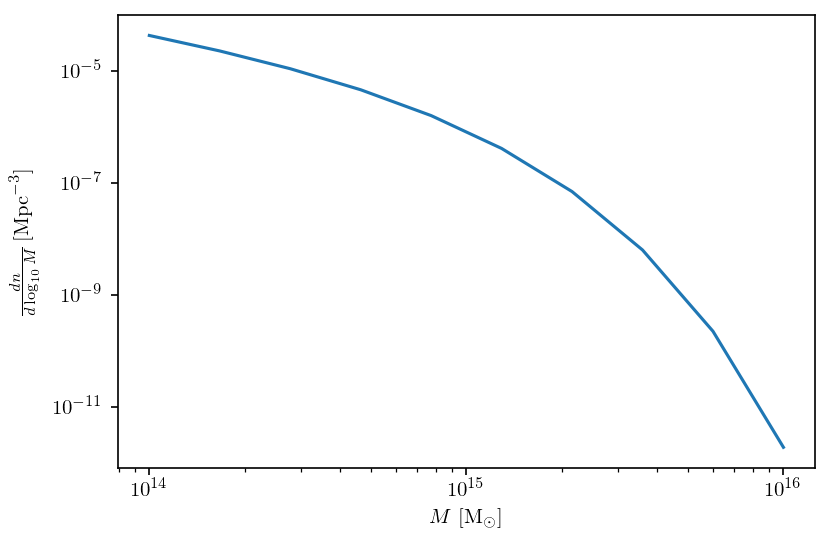

In [10]:
plt.figure()
plt.ylabel(r'$\frac{dn}{d\log_{10}M}\,[{\rm Mpc}^{-3}]$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.plot(masses, hmc, c=color_map(0))

In [11]:
ccl.halos.hmfunc.MassFuncBocquet16.get_mass_function

<function pyccl.halos.hmfunc.MassFunc.get_mass_function(self, cosmo, M, a, mdef_other=None)>

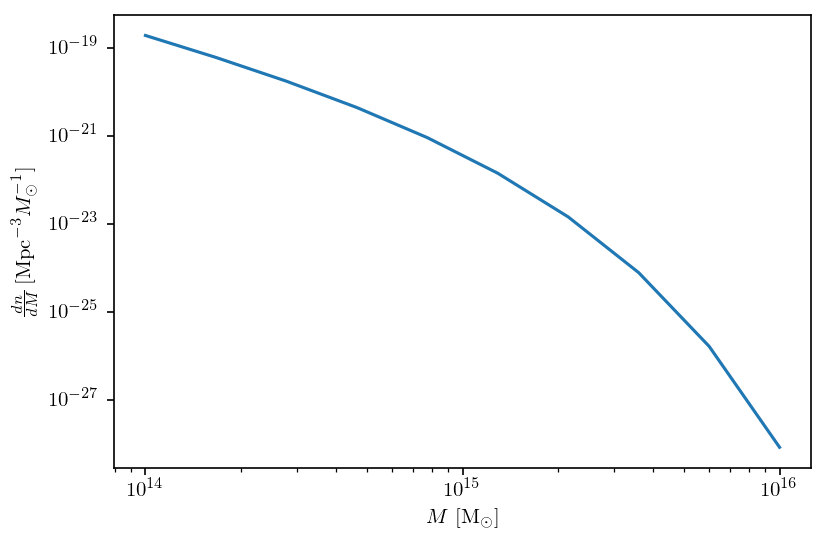

In [12]:
plt.figure()
plt.ylabel(r'$\frac{dn}{dM}\,[{\rm Mpc}^{-3}M_{\odot}^{-1}]$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.plot(masses, hmc/(masses*np.log(10)), c=color_map(0))

In [13]:
N_M = np.zeros(len(masses))
N_M

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
for i in range(len(masses)):
    N_M[i] = n_counts_func.halo_mass_function_z_bin(theta_fiducial, masses[i], 0.5, 0.75)
N_M

array([3.83292935e-09, 8.98455279e-10, 1.74690489e-10, 2.61293561e-11,
       2.69955110e-12, 1.64830066e-13, 4.73811674e-15, 4.58083754e-17,
       8.96693688e-20, 1.62021956e-23])

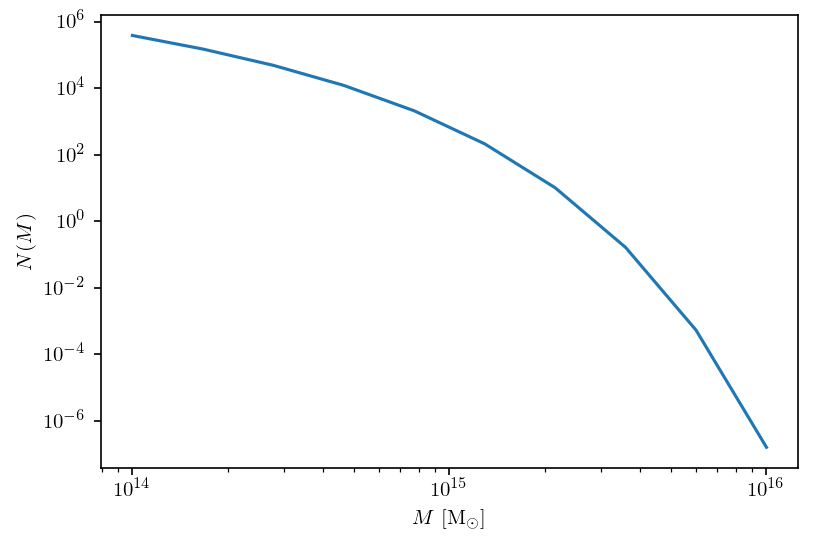

In [14]:
plt.figure()
plt.ylabel(r'$N(M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.plot(masses, masses*N_M, c=color_map(0))

In [21]:
n_counts_func.halo_mass_function_z_bin_new(14, theta_fiducial, 0.5, 0.6)

349894.74675046146

# Try Stuff

In [15]:
# Cosmology modulus
def cosmo(theta):
    # create a flat cosmology with massive neutrinos and some other default params
        
    # $\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}
    Omega_cdm = theta[0]/(theta[3]**2)
    Omega_b = theta[1]/(theta[3]**2)
    sigma8 = theta[2]
    h = theta[3]
    n_s = theta[4]
    w0 = theta[5]
        
    # setting up different cosmology configuration to match benchmarks and keep CLASS from crashing.
    cosmo_ccl = ccl.Cosmology(Omega_c= Omega_cdm, Omega_b= Omega_b, sigma8= sigma8,
                                      h= h, n_s= n_s, w0= w0,
                                      Omega_g=0, Omega_k=0,
                                      Neff=0, m_nu=0.0,
                                      wa=0, T_CMB=2.7, transfer_function='bbks',mass_function='tinker')
        
    return cosmo_ccl

# compute halo mass function (at a given redshift z for a given range of masses)
def halo_mass_function(theta, masses, z):
    cosmo_ccl = cosmo(theta)
    scale_fact_a = 1/(1+z)
        
    # using Sheth et al. (1999) halo mass function - but we could extend it to other halo mass functions
    mass_funct = ccl.halos.hmfunc.MassFuncBocquet16(cosmo_ccl)
        
    # calculate halo mass function for a given redshift and a given range of masses
    dn_dM = mass_funct.get_mass_function(cosmo_ccl, masses, scale_fact_a)
        
    return dn_dM



def halo_mass_function_z_bin(theta, mass, z_min, z_max):
    result = integrate.quad(integrand_hmf_z, z_min, z_max, args=(theta, mass))
    
    return result[0]

def integrand_hmf_z(x, theta, mass):
    cosmo_ccl = cosmo(theta)
    scale_fact_a = 1/(1+x)
    H0 = 100*theta[3]
    c = ccl.physical_constants.CLIGHT*1e-3
    H_z = H0*ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
    
    # using Sheth et al. (1999) halo mass function - but we could extend it to other halo mass functions
    mass_funct = ccl.halos.hmfunc.MassFuncBocquet16(cosmo_ccl)
        
    # calculate halo mass function for a given redshift and a given range of masses
    dn_dlog10M = mass_funct.get_mass_function(cosmo_ccl, mass, scale_fact_a)
        
    express = 4*np.pi*(c/H_z)*(ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)**2)*dn_dlog10M/(mass*np.log(10))
    
    return express



In [16]:
############ some new stuff ########################

def integrand_hmf_z_new(x, theta, mass):
    cosmo_ccl = cosmo(theta)
    scale_fact_a = 1/(1+x)
    H0 = 100*theta[3]
    c = ccl.physical_constants.CLIGHT*1e-3
    H_z = H0*ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
    
    # using Sheth et al. (1999) halo mass function - but we could extend it to other halo mass functions
    mass_funct = ccl.halos.hmfunc.MassFuncBocquet16(cosmo_ccl)
        
    # calculate halo mass function for a given redshift and a given range of masses
    dn_dlog10M = mass_funct.get_mass_function(cosmo_ccl, mass, scale_fact_a)
        
    express = 4*np.pi*(c/H_z)*(ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)**2)*dn_dlog10M
    
    return express


def halo_mass_function_z_bin_new(log10mass, theta, z_min, z_max):
    result = integrate.quad(integrand_hmf_z_new, z_min, z_max, args=(theta, 10**log10mass))
    
    return result[0]

def halo_mass_function_m_bin_new(theta, mass_min, mass_max, z_min, z_max):
    result_m = integrate.quad(halo_mass_function_z_bin_new, np.log10(mass_min), np.log10(mass_max), args = (theta, z_min, z_max))
    
    return result_m[0]

In [17]:
def n_counts_m_integral(log10mass, z, theta):
    cosmo_ccl = cosmo(theta)
    scale_fact_a = 1/(1+z)
    
    # using Sheth et al. (1999) halo mass function - but we could extend it to other halo mass functions
    mass_funct = ccl.halos.hmfunc.MassFuncSheth99(cosmo_ccl)
        
    # calculate halo mass function for a given redshift and a given range of masses
    dn_dlog10M = mass_funct.get_mass_function(cosmo_ccl, 10**log10mass, scale_fact_a)
    
    return dn_dlog10M

In [18]:
def n_counts_full_integral(z, theta): # log10mass_min, log10mass_max, theta):
    cosmo_ccl = cosmo(theta)
    scale_fact_a = 1/(1+z)
    
    H0 = 100*theta[3]
    c = ccl.physical_constants.CLIGHT*1e-3 # in km/s
    H_z = H0*ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
    
    # compute integral in m
    integral_m = integrate.quad(n_counts_m_integral, 14, 14.5, args=(z, theta))[0]
    
    # compute full expression
    express = 4*np.pi*(c/H_z)*(ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)**2)*integral_m
    return express

In [21]:
integrate.quad(n_counts_full_integral, 0.5, 0.6, args=(theta_fiducial))

(79195.81649036697, 0.0001264295352747407)

In [63]:
def n_counts_full_integral2(z, log10mass_min, log10mass_max, theta):
    cosmo_ccl = cosmo(theta)
    scale_fact_a = 1/(1+z)
    
    H0 = 100*theta[3]
    c = ccl.physical_constants.CLIGHT*1e-3 # in km/s
    H_z = H0*ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
    
    # compute integral in m
    integral_m = integrate.quad(n_counts_m_integral, log10mass_min, log10mass_max, args=(z, theta))[0]
    
    # compute full expression
    express = 4*np.pi*(c/H_z)*(ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)**2)*integral_m
    return express

In [64]:
integrate.quad(n_counts_full_integral2, 0.5, 0.6, args=(14, 14.5, theta_fiducial))

(79195.81649036697, 0.0001264295352747407)

In [67]:
log10masses = np.linspace(14, 16, num = 5)
print(log10masses)

[14.  14.5 15.  15.5 16. ]


In [69]:
N_counts = []
z_min = 0.1
z_max = 0.2
for i in range(len(log10masses) - 1):
    N_counts_temp = integrate.quad(n_counts_full_integral2, z_min, z_max, args=(log10masses[i], log10masses[i+1], theta_fiducial))
    N_counts.append(N_counts_temp)
    print(i)

0
1
2
3


In [82]:
N_counts_arr = np.asarray(N_counts)[:,0]

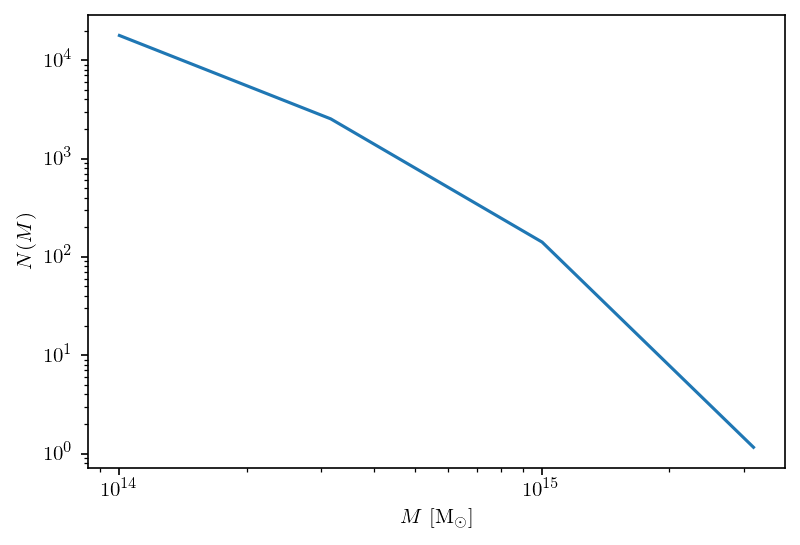

In [83]:
plt.figure()
plt.ylabel(r'$N(M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.plot(10**log10masses[:-1], N_counts_arr, c=color_map(0))

In [94]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)

In [95]:
N_counts = np.zeros((len(log10masses)-1, len(z_min)))
N_counts

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [96]:
for i in range(len(log10masses) - 1):
    for j in range(len(z_min)):
        N_counts_temp = integrate.quad(n_counts_full_integral2, z_min[j], z_max[j], args=(log10masses[i], log10masses[i+1], theta_fiducial))
        N_counts[i][j] = N_counts_temp[0]
        print(i, j)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4


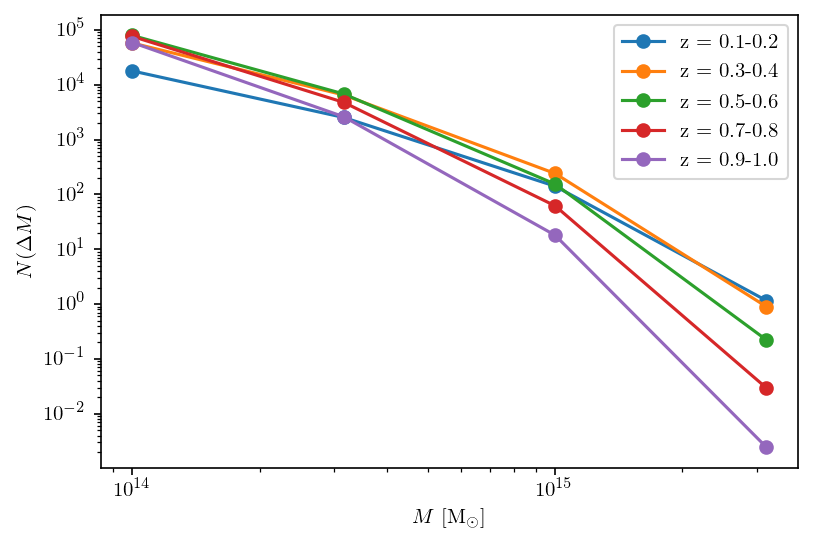

In [99]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
for j in range(len(z_min)):
    plt.plot(10**log10masses[:-1], N_counts[:, j], c=color_map(j), marker = 'o', label = 'z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
plt.legend(loc = 'best')    
    

In [113]:
N_counts_random = np.zeros((len(log10masses)-1, len(z_min)))
N_counts_random_mean = np.zeros((len(log10masses)-1, len(z_min)))

In [114]:
for i in range(len(log10masses) - 1):
    for j in range(len(z_min)):
        N_counts_random[i][j] = np.random.poisson(N_counts[i][j])
        N_counts_random_mean[i][j] = np.mean(np.random.poisson(N_counts[i][j], 100))

N_counts_random

array([[1.7976e+04, 5.7393e+04, 7.8917e+04, 7.5820e+04, 5.8943e+04],
       [2.5170e+03, 6.4920e+03, 6.7990e+03, 4.7030e+03, 2.6220e+03],
       [1.5700e+02, 2.3600e+02, 1.5100e+02, 6.0000e+01, 9.0000e+00],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

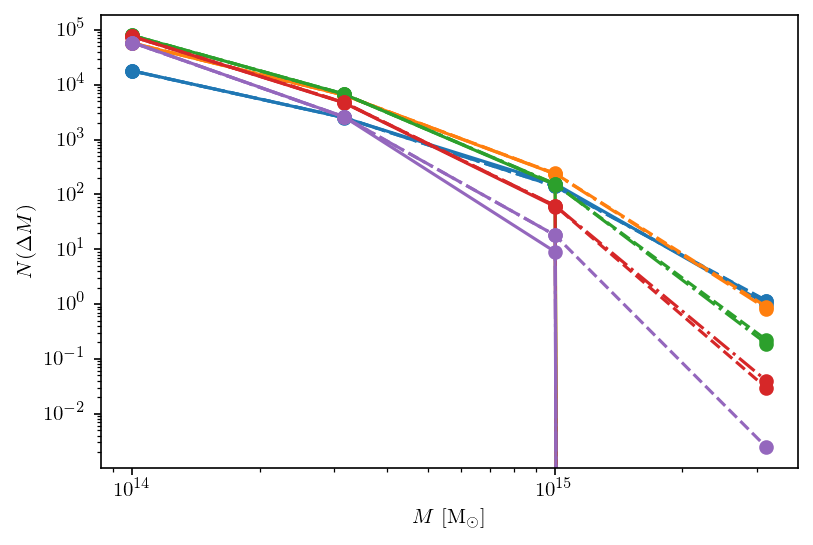

In [119]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
for j in range(len(z_min)):
    plt.plot(10**log10masses[:-1], N_counts[:, j], c=color_map(j), linestyle='dashed', marker = 'o', label = 'og z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.plot(10**log10masses[:-1], N_counts_random[:, j], c=color_map(j), marker = 'o', label = 'z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.plot(10**log10masses[:-1], N_counts_random_mean[:, j], c=color_map(j), linestyle = '-.', marker = 'o', label = 'mean z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))

#plt.legend(loc = 'best')    
    

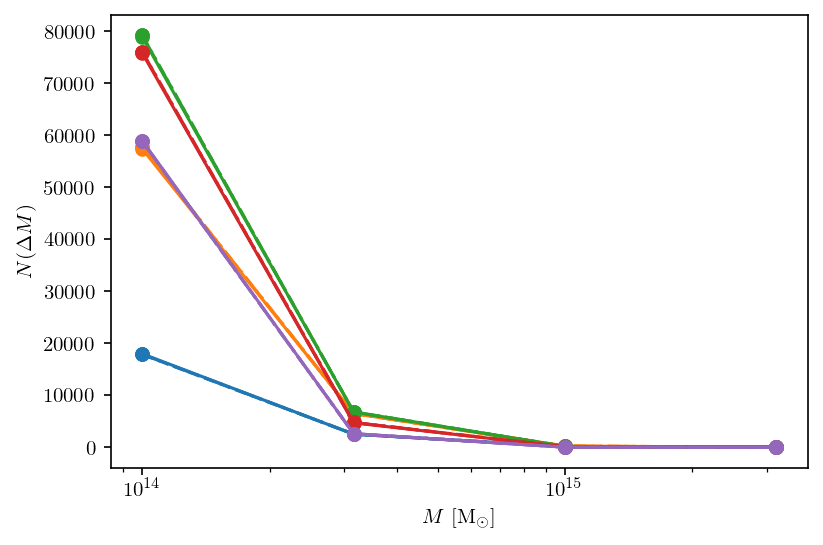

In [120]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('linear')
for j in range(len(z_min)):
    plt.plot(10**log10masses[:-1], N_counts[:, j], c=color_map(j), linestyle='dashed', marker = 'o', label = 'og z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.plot(10**log10masses[:-1], N_counts_random[:, j], c=color_map(j), marker = 'o', label = 'z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.plot(10**log10masses[:-1], N_counts_random_mean[:, j], c=color_map(j), linestyle = '-.', marker = 'o', label = 'mean z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))

#plt.legend(loc = 'best')  

In [117]:
N_counts_random

array([[1.7976e+04, 5.7393e+04, 7.8917e+04, 7.5820e+04, 5.8943e+04],
       [2.5170e+03, 6.4920e+03, 6.7990e+03, 4.7030e+03, 2.6220e+03],
       [1.5700e+02, 2.3600e+02, 1.5100e+02, 6.0000e+01, 9.0000e+00],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [122]:
log10masses_detailed = np.linspace(14, 16, num = 10)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)

In [136]:
N_counts_detailed = np.zeros((len(log10masses_detailed)-1, len(z_min)))
N_counts_random_detailed = np.zeros((len(log10masses_detailed)-1, len(z_min)))
N_counts_random_mean_detailed = np.zeros((len(log10masses_detailed)-1, len(z_min)))
N_counts_detailed

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [137]:
for i in range(len(log10masses_detailed) - 1):
    for j in range(len(z_min)):
        N_counts_temp = integrate.quad(n_counts_full_integral2, z_min[j], z_max[j], args=(log10masses_detailed[i], log10masses_detailed[i+1], theta_fiducial))
        N_counts_detailed[i][j] = N_counts_temp[0]
        print(i, j)
N_counts_detailed

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
6 0
6 1
6 2
6 3
6 4
7 0
7 1
7 2
7 3
7 4
8 0
8 1
8 2
8 3
8 4


array([[1.15800327e+04, 3.85834339e+04, 5.48042661e+04, 5.45712084e+04,
        4.38588032e+04],
       [5.47583409e+03, 1.68390172e+04, 2.16995672e+04, 1.92924755e+04,
        1.36313954e+04],
       [2.31865812e+03, 6.41774238e+03, 7.27956167e+03, 5.58042923e+03,
        3.33262858e+03],
       [8.41486306e+02, 2.02583289e+03, 1.94110400e+03, 1.22370005e+03,
        5.85668406e+02],
       [2.45808466e+02, 4.91071578e+02, 3.75712289e+02, 1.82594335e+02,
        6.51411299e+01],
       [5.27963288e+01, 8.20251564e+01, 4.63703653e+01, 1.58960505e+01,
        3.82588664e+00],
       [7.31509284e+00, 8.07561038e+00, 3.02840186e+00, 6.46889355e-01,
        9.13048543e-02],
       [5.40535285e-01, 3.73460918e-01, 7.97280515e-02, 8.88482564e-03,
        6.00325839e-04],
       [1.60960875e-02, 5.79328709e-03, 5.62797655e-04, 2.51510800e-05,
        6.01111023e-07]])

In [138]:
N_counts_random_var_detailed = np.zeros((len(log10masses_detailed)-1, len(z_min)))

In [140]:
for i in range(len(log10masses_detailed) - 1):
    for j in range(len(z_min)):
        N_counts_random_arr_detailed = np.random.poisson(N_counts_detailed[i][j], 100)
        N_counts_random_mean_detailed[i][j] = np.mean(N_counts_random_arr_detailed)
        N_counts_random_var_detailed[i][j] = np.var(N_counts_random_arr_detailed)
N_counts_random_mean_detailed


array([[1.158201e+04, 3.855427e+04, 5.480429e+04, 5.458782e+04,
        4.385724e+04],
       [5.474580e+03, 1.684756e+04, 2.171374e+04, 1.928909e+04,
        1.365613e+04],
       [2.315530e+03, 6.413670e+03, 7.278720e+03, 5.572230e+03,
        3.323130e+03],
       [8.442400e+02, 2.021900e+03, 1.938690e+03, 1.217850e+03,
        5.859000e+02],
       [2.471400e+02, 4.894900e+02, 3.781900e+02, 1.829600e+02,
        6.439000e+01],
       [5.287000e+01, 8.281000e+01, 4.662000e+01, 1.607000e+01,
        3.970000e+00],
       [7.250000e+00, 8.450000e+00, 3.070000e+00, 7.100000e-01,
        1.100000e-01],
       [4.500000e-01, 3.200000e-01, 5.000000e-02, 3.000000e-02,
        0.000000e+00],
       [1.000000e-02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00]])

In [141]:
N_counts_random_var_detailed

array([[9.10840990e+03, 3.97675371e+04, 4.59156659e+04, 5.67031476e+04,
        3.16554424e+04],
       [5.51896360e+03, 1.20694464e+04, 2.26114324e+04, 1.50395419e+04,
        1.07326331e+04],
       [2.11180910e+03, 9.00812110e+03, 8.07908160e+03, 4.88149710e+03,
        3.49105310e+03],
       [6.99622400e+02, 2.39467000e+03, 1.68503390e+03, 1.20452750e+03,
        5.40850000e+02],
       [2.87620400e+02, 5.33109900e+02, 3.57733900e+02, 1.76178400e+02,
        7.72579000e+01],
       [5.01331000e+01, 9.33339000e+01, 5.01356000e+01, 1.35251000e+01,
        5.52910000e+00],
       [7.30750000e+00, 8.10750000e+00, 2.98510000e+00, 6.85900000e-01,
        9.79000000e-02],
       [3.47500000e-01, 2.77600000e-01, 4.75000000e-02, 2.91000000e-02,
        0.00000000e+00],
       [9.90000000e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

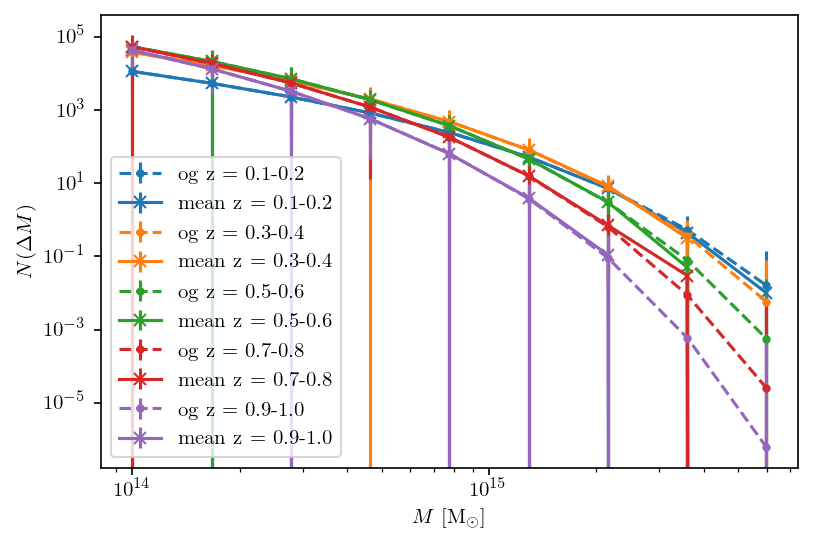

In [152]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e15, 1e16)
#plt.ylim(0, 300)
for j in range(len(z_min)):
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_detailed[:, j], yerr=np.sqrt(N_counts_detailed[:, j]),
                 c=color_map(j), linestyle = '--', marker = '.', label = 'og z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_random_mean_detailed[:, j], yerr=N_counts_random_var_detailed[:, j],
                 c=color_map(j), marker = 'x', label = 'mean z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
plt.legend(loc = 'best')    
    

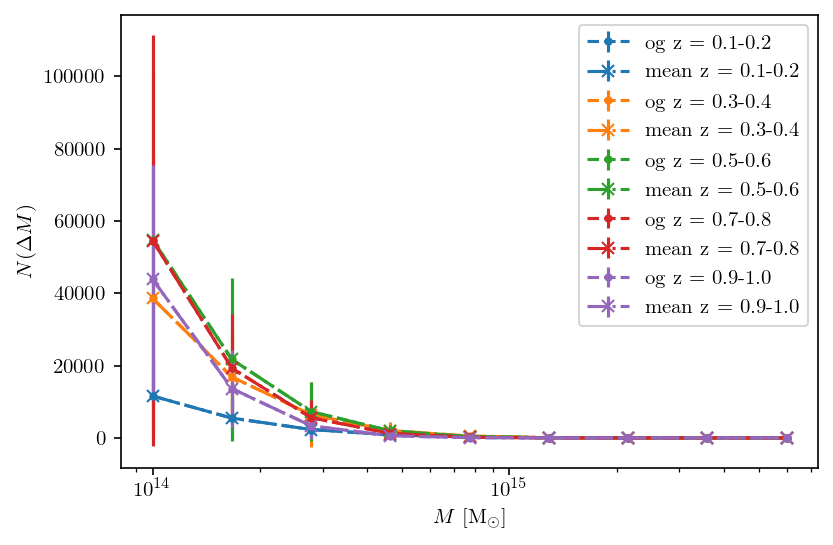

In [151]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e15, 1e16)
#plt.ylim(0, 300)
for j in range(len(z_min)):
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_detailed[:, j], yerr=np.sqrt(N_counts_detailed[:, j]),
                 c=color_map(j), linestyle = '--', marker = '.', label = 'og z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_random_mean_detailed[:, j], yerr=N_counts_random_var_detailed[:, j],
                 c=color_map(j), linestyle = '-.', marker = 'x', label = 'mean z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
plt.legend(loc = 'best')    
    

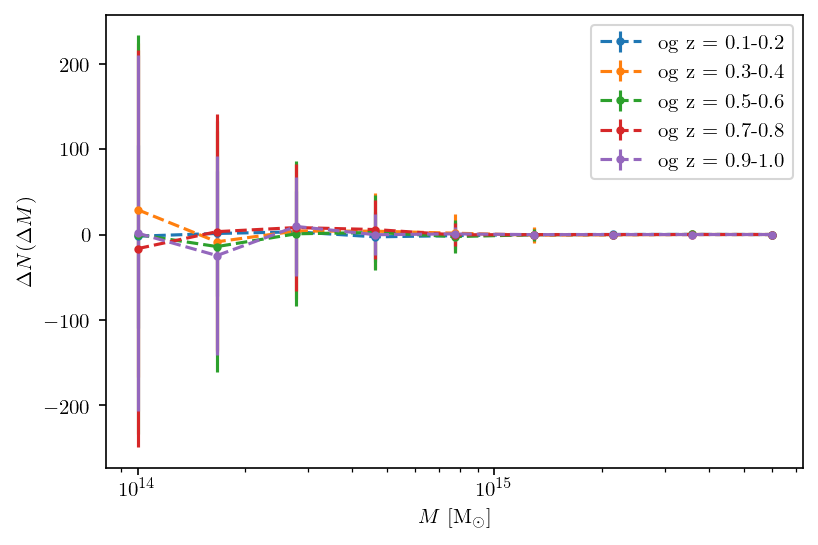

In [150]:
plt.figure()
plt.ylabel(r'$\Delta N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e15, 1e16)
#plt.ylim(0, 300)
for j in range(len(z_min)):
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_detailed[:, j] -N_counts_random_mean_detailed[:, j] , yerr=np.sqrt(N_counts_detailed[:, j]),
                 c=color_map(j), linestyle = '--', marker = '.', label = 'og z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.legend(loc = 'best')    
    

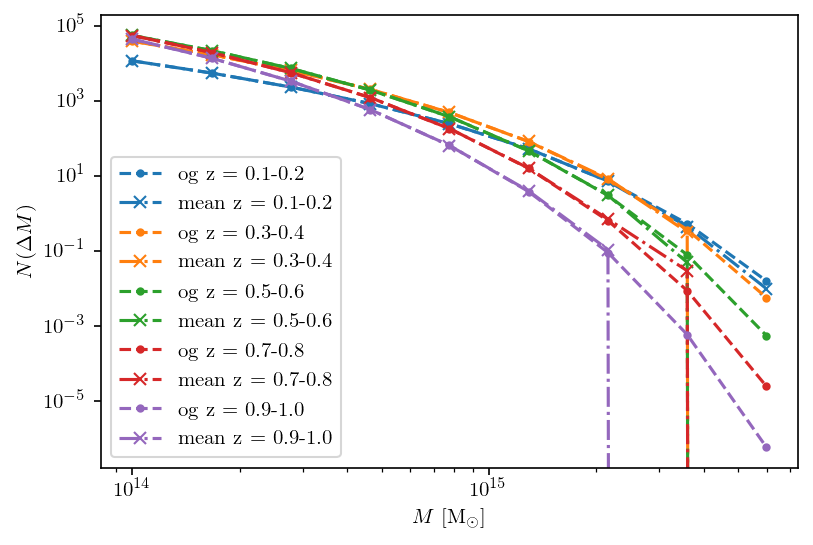

In [153]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e15, 1e16)
#plt.ylim(0, 300)
for j in range(len(z_min)):
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_detailed[:, j],
                 c=color_map(j), linestyle = '--', marker = '.', label = 'og z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_random_mean_detailed[:, j],
                 c=color_map(j), linestyle = '-.', marker = 'x', label = 'mean z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
plt.legend(loc = 'best')    
    

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [ ]:
ccl.halos.hmfunc.MassFunc

In [ ]:
ccl.halos.hmfunc.MassFunc.get_mass_function

In [ ]:
ccl.massfunc

In [11]:
np.random.seed(2)

In [10]:
# setting up different cosmology configuration to match benchmarks and keep CLASS from crashing.
cosmo_ccl1_mf = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, Omega_g=0, Omega_k=0,
                       h=0.7, sigma8=0.8, n_s=0.96, Neff=0, m_nu=0.0,
                       w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                       mass_function='tinker')

In [4]:
#Load the benchmarks
bench=np.loadtxt('/home/aizhana/CCL/benchmarks/data/model1_hmf.txt')
log10mass = bench[0:,0]
sigma = bench[0:,1]
log10invsigma = bench[0:,2]
log10massfunc = bench[0:,3]

In [5]:
bench

array([[ 1.000000e+01,  3.605507e+00, -5.569663e-01, -1.570650e+00],
       [ 1.050000e+01,  3.204972e+00, -5.058242e-01, -1.518198e+00],
       [ 1.100000e+01,  2.821836e+00, -4.505318e-01, -1.462083e+00],
       [ 1.150000e+01,  2.457596e+00, -3.905104e-01, -1.402880e+00],
       [ 1.200000e+01,  2.113854e+00, -3.250751e-01, -1.342187e+00],
       [ 1.250000e+01,  1.792304e+00, -2.534117e-01, -1.283641e+00],
       [ 1.300000e+01,  1.494680e+00, -1.745481e-01, -1.234955e+00],
       [ 1.350000e+01,  1.222696e+00, -8.731863e-02, -1.212136e+00],
       [ 1.400000e+01,  9.779681e-01,  9.675300e-03, -1.248659e+00],
       [ 1.450000e+01,  7.619025e-01,  1.181006e-01, -1.416499e+00],
       [ 1.500000e+01,  5.755757e-01,  2.398976e-01, -1.877337e+00],
       [ 1.550000e+01,  4.195639e-01,  3.772018e-01, -3.015292e+00],
       [ 1.600000e+01,  2.936924e-01,  5.321073e-01, -5.803086e+00]])

In [13]:
scale_fact = 1.

# setting up different cosmology configuration to match benchmarks and keep CLASS from crashing.
cosmo_ccl1_mf = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, Omega_g=0, Omega_k=0,
                       h=0.7, sigma8=0.8, n_s=0.96, Neff=0, m_nu=0.0,
                       w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                       mass_function='tinker')

In [14]:
cosmo_ccl1_mf

pyccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, n_s=0.96, sigma8=0.8, A_s=None, Omega_k=0, Omega_g=0, Neff=0, w0=-1, wa=0, T_CMB=2.7, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='bbks', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker', halo_concentration='duffy2008', emulator_neutrinos='strict')

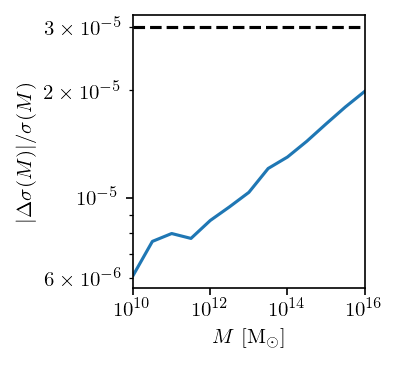

<Figure size 900x600 with 0 Axes>

In [6]:
accuracy = 3e-5

mass_function_fig_size = (paper_textwidth/3, fig_size[1])
mass_function_plot_adjust = plot_adjust.copy()
mass_function_plot_adjust["left"] = 0.3
mass_function_plot_adjust["right"] = 0.95

#This plot shows the relative difference in sigmaM predictions.
plt.figure(figsize=mass_function_fig_size)
plt.gcf().subplots_adjust(**mass_function_plot_adjust)
plt.ylabel(r'$|\Delta \sigma(M)|/\sigma(M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.gca().set_xscale('log')
plt.plot(10**log10mass, np.abs(ccl.sigmaM(cosmo_ccl1_mf,10**log10mass,scale_fact)/sigma-1),
        c=color_map(0))
plt.axhline(accuracy, c="k", ls="--")
plt.yscale("log")
plt.locator_params(axis="x", numticks=4)
plt.xlim(left=1e10,right=1e16)
plt.savefig('hmf_model1.pdf')
plt.show()
plt.clf()

In [15]:
import matplotlib.pyplot as plt

In [22]:
log10mass1 = bench[5:-2,0]
log10mass1

array([12.5, 13. , 13.5, 14. , 14.5, 15. ])

/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pyccl/pyutils.py:407: CCLWarning: The function massfunc is deprecated. Use MassFunc instead.
  warnings.warn(s, CCLWarning)


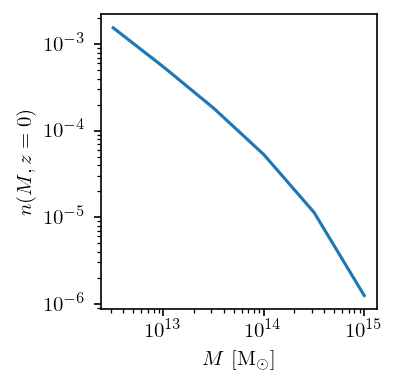

In [23]:
plt.figure(figsize=mass_function_fig_size)
plt.ylabel(r'$n(M, z=0)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e13, 1e15)
plt.plot(10**log10mass1, ccl.massfunc(cosmo_ccl1_mf,10**log10mass1,scale_fact), c=color_map(0))

In [9]:
ccl.tracers.NumberCountsTracer

pyccl.tracers.NumberCountsTracer

## Set up the prior on parameters

In [3]:
# param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'] 

lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior = priors.Uniform(lower, upper)

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

# Step 2 - Specifying simulation vector
## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [4]:
JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

/home/aizhana/pydelfi/examples/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [5]:
theta_fiducial = np.array([0.3, -0.75, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

# Step 1 - Specifying data vector. 
## Here the data vector is a compressed data vector

In [6]:
compressed_data = compressor(JLASimulator.data, compressor_args)

## Define ensemble of NDEs

In [7]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=6, n_data=6, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [8]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                            results_dir = "simulators/jla_supernovae/results/",
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs

Sampling approximate posterior...
Done.
Removed no burn in


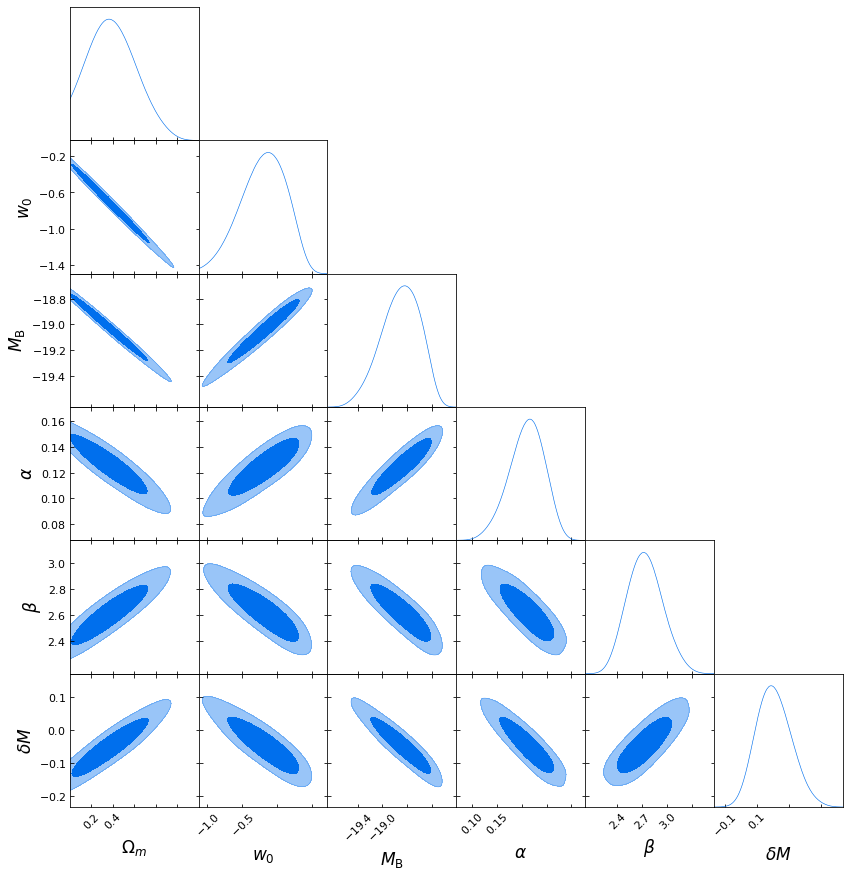

In [8]:
DelfiEnsemble.fisher_pretraining()

## Sequential Neural Likelihood

Population 1/20
Sampling proposal density...
Done.


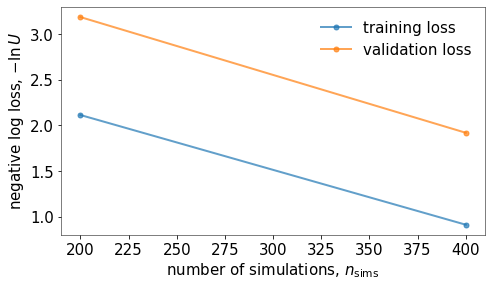

Population 2/20
Sampling proposal density...
Done.


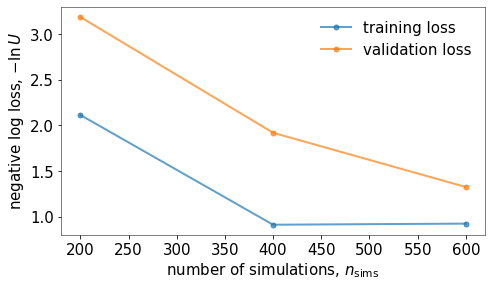

Population 3/20
Sampling proposal density...
Done.


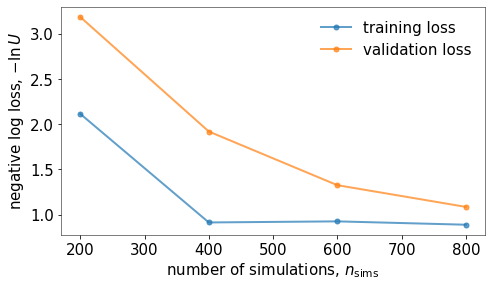

Population 4/20
Sampling proposal density...
Done.


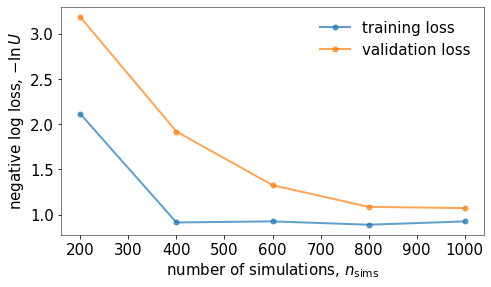

Population 5/20
Sampling proposal density...
Done.


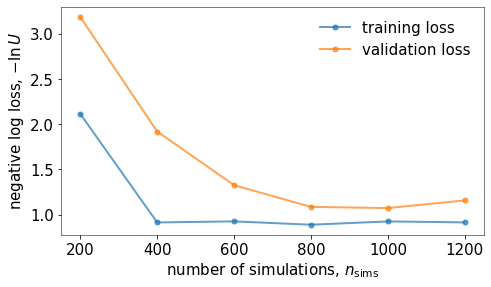

Population 6/20
Sampling proposal density...
Done.


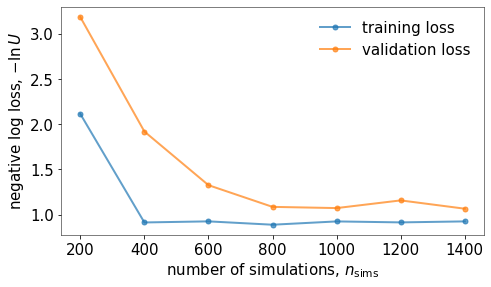

Population 7/20
Sampling proposal density...
Done.


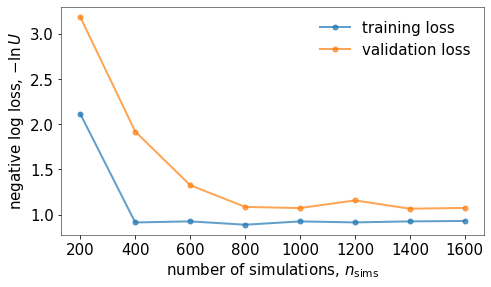

Population 8/20
Sampling proposal density...
Done.


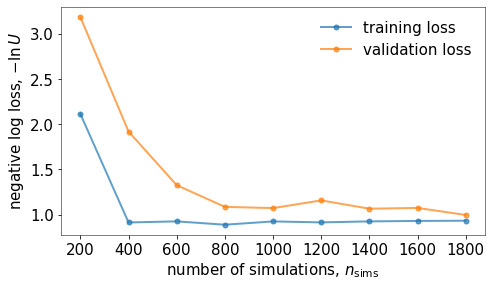

Population 9/20
Sampling proposal density...
Done.


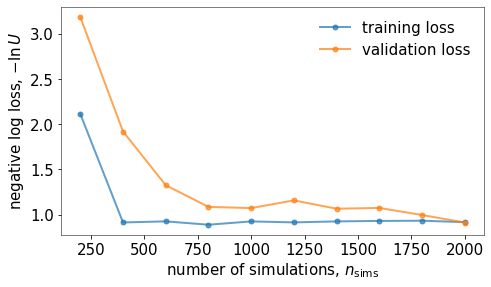

Population 10/20
Sampling proposal density...
Done.


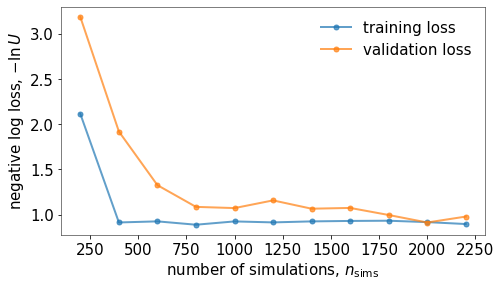

Population 11/20
Sampling proposal density...
Done.


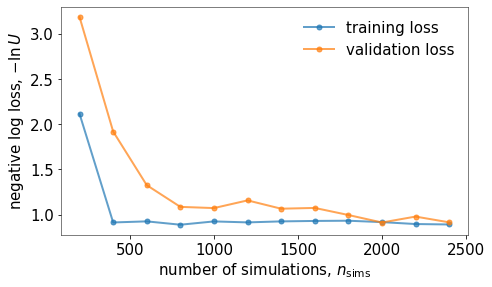

Population 12/20
Sampling proposal density...
Done.


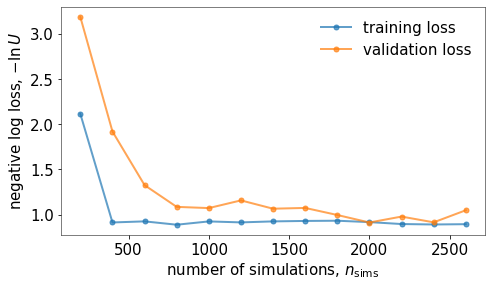

Population 13/20
Sampling proposal density...
Done.


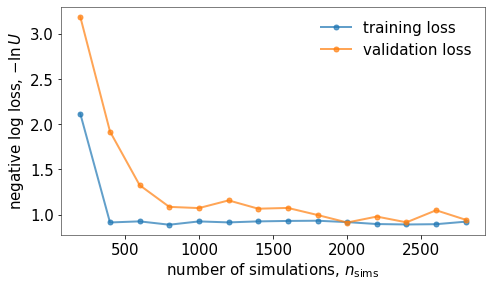

Population 14/20
Sampling proposal density...
Done.


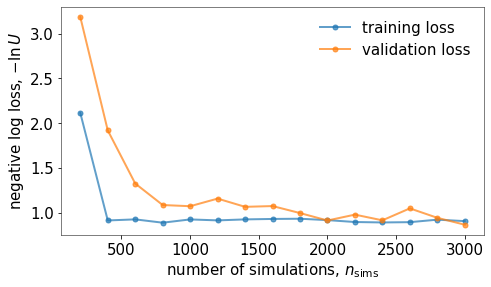

Population 15/20
Sampling proposal density...
Done.


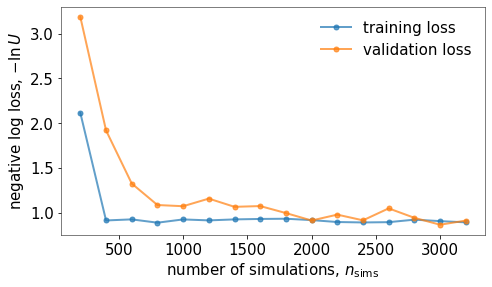

Population 16/20
Sampling proposal density...
Done.


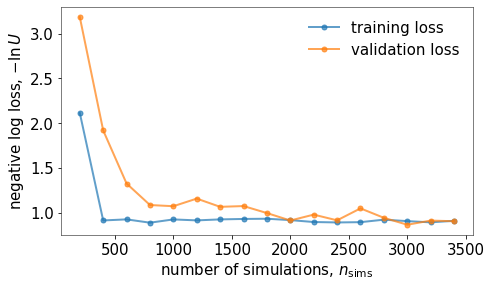

Population 17/20
Sampling proposal density...
Done.


In [ ]:
n_initial = 200
n_batch = 200
n_populations = 20

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=False)

## Sample the learned posterior

In [ ]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [ ]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])